### 一.特征工程
特征工程是比较重要的一环了，这一节先只介绍一些常用的特征工程手段，更多关于特征的操作放到后面模型优化中讲，因为业务建模通常需要尽快有一个快速的输出，而各种各样特征工程的探索一般比较耗时，往往在后期优化中进行，下面分别介绍如下几种：   

（1）categorical 变量的处理；   

（2）数据分箱；   

（3）WOE特征； 

（4）数据归一化操作(z-score,min-max,normalize,log,boxcox,cdf,pdf变换等)；   

#### categorical 变量的处理
对于一般的机器学习模型，往往只支持数值型输入（lgb,catboost除外），所以第一步就是要将非数值型特征转换为数值型特征，这里我们可以按之前介绍的变量功能进行处理：    

（1）对于可比较的特征，比如“高”、“中”、“低”这类，可以考虑LabelEncoding，将其编码为可比较的数值，比如3,2,1;    

（2）对于不可比较的特征，比如行为爱好类：“游戏”，“篮球”，“跑步”....它们没法直接进行比较，所以对其编码3,2,1没有比较意义，对于线性模型这样与特征起着正相关性/负相关性的模型会有副作用，这时我们可以分两类看：   

> （2.1）low-cardinality categorical特征：即分类数较少的特征，可以考虑作one-hot一类的特征转换；   

> （2.2）high-cardinality categorical 特征：即分类数较多的特征，比如id,时间这样的特征，如果作ont-hot展开，会引起维度爆炸，而且对单个特征会有严重的数据不平衡问题，这时可以考虑使用target encoding,catboost encoding等特征转换  

我对这一块的了解并不多，建议参考:http://contrib.scikit-learn.org/categorical-encoding/  

画根线：  

**对于树模型，使用one-hot编码要慎重，如果选择one-hot特征作切分可能会导致切分后的左右子树极端不平衡，对于样本量少的一边，其统计值（均值、众数）偏差往往很大，模型容易过拟合**

In [1]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
train_df=pd.read_csv('./titanic/train.csv')
test_df=pd.read_csv('./titanic/test.csv')
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df['Cabin'].fillna('missing',inplace=True)
test_df['Cabin'].fillna('missing',inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0],inplace=True)
train_df['Age'].fillna(train_df['Age'].mean(),inplace=True)
test_df['Age'].fillna(train_df['Age'].mean(),inplace=True)
test_df['Fare'].fillna(train_df['Fare'].mean(),inplace=True)

In [3]:
import category_encoders as ce
del train_df['Name']
del train_df['Ticket']
del test_df['Name']
del test_df['Ticket']
del train_df['PassengerId']
del test_df['PassengerId']
label=train_df["Survived"]
del train_df["Survived"]
# target 
target_encoder = ce.TargetEncoder(cols=['Embarked','Cabin']).fit(train_df,label)
train_df=target_encoder.transform(train_df)
test_df=target_encoder.transform(test_df)

# one hot
onehot_encoder = ce.OneHotEncoder(cols=['Sex']).fit(train_df)
train_df=onehot_encoder.transform(train_df)
test_df=onehot_encoder.transform(test_df)

#### 数据分箱
数据分箱也是比较常见的操作，在一定程度上增加了数据的颗粒度，能避免过拟合，分箱的方式很多按照有监督和无监督可以分为：   

（1）无监督：等距分箱，等频分箱，聚类分箱（后面会有用到），二值分箱；   

（2）有监督：卡方分箱，最小熵分箱   

[参考>>>](https://mp.weixin.qq.com/s?__biz=MzI4MjkzNTUxMw==&mid=2247484834&idx=1&sn=2ce321c5fa5e8df3b6d3c6b644aa141b&chksm=eb932c14dce4a502e05421a478796d9e2b8522dc583a609c77e2883b963c7670a5826c0a0c03&mpshare=1&scene=1&srcid=&sharer_sharetime=1586312923627&sharer_shareid=1e2e4bc7a27ef84a8a7e8bfedd080e02&key=a29eb00479c14a8ba349d29b5b684126f11bdaa6027411a066240c0a3c5e8b661e1466038e1df5822afaab891b3dff9677f96ffe7fdbefbf9884896a317d6f2257c8ed823eff434953cedbe74113d645&ascene=1&uin=MTk4MzMwODY4Mg%3D%3D&devicetype=Windows+10&version=62080079&lang=zh_CN&exportkey=A0CyFLsd47G%2BXNIR%2FFB6kfk%3D&pass_ticket=rfTc5pQJI1Ast4NBu%2BmXt3UDs%2FbiY3EnhijxRpOOGWVafOmugaq8EmMUfGDYL1OL)

In [4]:
#对Fare等频分箱
train_df['Fare_bins'],bins=pd.cut(train_df['Fare'],bins=10,labels=False,retbins=True)
test_df['Fare_bins']=pd.cut(test_df['Fare'],bins=bins,labels=False)

#### WOE
WOE特征可以非常直观的表达当前分箱后的特征取值对y的贡献大小，它的计算公式：   

$$
WOE(feature_i)=ln(\frac{N(y_{feature_i}=1)}{N(y_{feature_i}=0)})
$$

$feature_i$表示$feature$的第$i$个取值，$N(y_{feature_i}=1)$表示特征$feature$的第$i$个取值对应的$y=1$的数量

参考:https://zhuanlan.zhihu.com/p/30026040

In [5]:
#计算训练集上的woe
train_df['y']=label
pos_df=(train_df[['Fare_bins','y']][train_df['y']==1]).groupby(by=['Fare_bins'])['y'].count().reset_index()
pos_df.columns=['Fare_bins','pos']
neg_df=(train_df[['Fare_bins','y']][train_df['y']==0]).groupby(by=['Fare_bins'])['y'].count().reset_index()
neg_df.columns=['Fare_bins','neg']
woe_df=pd.merge(pos_df,neg_df,on='Fare_bins')
woe_df['woe']=np.log(woe_df['pos']/(1e-3+woe_df['neg'])+1e-5)

In [6]:
woe_df[['Fare_bins','woe']]

,Fare_bins,woe
0,0,-0.761548
1,1,0.664954
2,2,1.055931
3,4,0.559372
4,5,0.692652


In [7]:
del train_df['y']
train_df=pd.merge(train_df,woe_df[['Fare_bins','woe']],how='left').fillna(0)
test_df=pd.merge(test_df,woe_df[['Fare_bins','woe']],how='left').fillna(0)

#### 数据归一化
数据是否需要标准化取决于后面的训练模型，对于树模型不需要归一化，而对于如下的模型往往需要归一化：   

（1）knn,kmeans：计算欧氏距离...  
（2）lr,svm,nn：便于梯度下降...  
（3）pca：偏向于值较大的列  


一般有以下几种：  
（1）z-score：$z=(x-u)/\sigma$  
（2）min-max：$m=(x-x_{min})/(x_{max}-x_{min})$  
（3）行归一化：$\sqrt{(x_1^2+x_2^2+\cdots+x_n^2)}=1,这里x_1,x_2,...,x_n表示每行特征$；  

更多：https://www.jianshu.com/p/fa73a07cd750

In [8]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
#z-score归一化为例
standard_scaler=StandardScaler()
standard_scaler.fit(train_df)
new_train_df=pd.DataFrame(standard_scaler.transform(train_df),columns=train_df.columns)
new_test_df=pd.DataFrame(standard_scaler.transform(test_df),columns=train_df.columns)

pdf:标准正态分布的概率密度函数

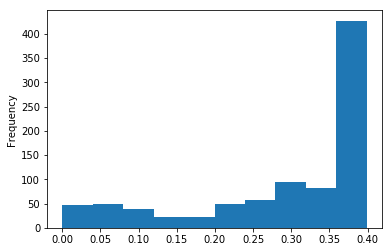

In [9]:
from scipy.stats import norm
age_mean=train_df['Age'].mean()
age_std=train_df['Age'].std()
new_train_df['age_pdf']=train_df['Age'].apply(lambda x:norm.pdf((x-age_mean)/age_std))
new_test_df['age_pdf']=test_df['Age'].apply(lambda x:norm.pdf((x-age_mean)/age_std))
new_train_df['age_pdf'].plot(kind='hist')

cdf:分布函数

In [10]:
new_train_df['age_cdf']=train_df['Age'].apply(lambda x:norm.cdf((x-age_mean)/age_std))
new_test_df['age_cdf']=test_df['Age'].apply(lambda x:norm.cdf((x-age_mean)/age_std))

boxcox:将任意分别转换为正态分布

$$
y=\left\{\begin{matrix}
\frac{(x^\lambda-1)}{\lambda} &\lambda>0 \\ 
log(x) &\lambda=0 
\end{matrix}\right.
$$

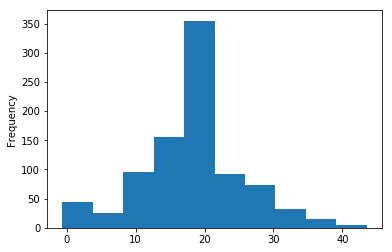

In [11]:
from scipy.stats import boxcox
new_train_df['age_boxcox']=boxcox(train_df['Age'])[0]
new_test_df['age_boxcox']=boxcox(test_df['Age'],lmbda=boxcox(train_df['Age'])[1])[0]
new_train_df['age_boxcox'].plot(kind='hist')

### 二.模型选择

首先，我们需要明白我们的建模的目标是什么？然后怎么去量化我们的目标？  


（1）**目标**：本数据集是预测乘客是否存活，所以可以看做是分类任务；  

（2）**量化目标**：选择合适的评估指标，这里我们可以选择f1；  

当然，从众多分类模型中选择一个较优的模型作为基准模型，是一个比较繁琐的工作，一般来说用的比较多是RF、LR、GBDT等，通常为了让模型的评估更加客观，我们需要选择交叉验证的方式  

In [12]:
classifier=LogisticRegression()
scores = cross_val_score(classifier, train_df, label, scoring='f1', cv = 5)#注意：f1只是看正样本的f1,如果要看整体的用f1_macro,但这一般会使得f1偏高
np.mean(scores),np.std(scores)

(0.7509734792424432, 0.01775967622151036)

In [13]:
#我们再看看另一种分类器
classifier=GradientBoostingClassifier()
scores = cross_val_score(classifier, train_df, label, scoring='f1', cv = 5)
np.mean(scores),np.std(scores)

(0.7753721187015974, 0.047352448054968535)

#### 偏差/方差
我们查看了f1的均值与标准差,其中，均值反映模型的预测能力，标准差可以反映模型的稳定性，按照术语来说前者反映了模型的偏差，后面反映了模型的方差，我们可以将模型的能力用类似于如下的图来定义，显然我们倾向于选择低偏差低方差的模型：  
![avatar](./source/方差与偏差.png)
来源:https://blog.csdn.net/hertzcat/article/details/80035330

#### 过拟合/欠拟合
过拟合/欠拟合也是检验模型好坏的一种评估手段，它通常应用在训练阶段：  

>（1）训练集/验证集效果都比较差，可以看作是欠拟合(除非训练数据真的是太差了)，这时可以增加模型的复杂度试一试；  

>（2）训练集的表现好，而验证集的表现差，大部分情况下是过拟合（这也是经常会遇到的问题）可以尝试一下的方法；     

过拟合的解决方法：   

1). 降低模型复杂度：1.换更简单的模型，2.正则化技术    

    
2). 增强训练数据 

**补充一点：**   

训练集上效果好，验证集上效果差，也有可能是数据分布差异大造成的影响，如果由于客观原因使得训练集和验证集不能从同一分布做随机采样（比如与时间相关的业务，只能使用T+1的数据做验证集），这时可以从训练集中分一小部分数据出来不做训练，然后对比结果：   

（1）如果未训练的样本效果与训练集一致，那么可能是数据分布差异带来的影响；   

（2）如果未训练的样本效果与验证集一致，那么过拟合的可能性更大；  

![avatar](./source/过拟合与数据差异进行对比.png)
